### Basic Chatbot with Langgraph (GraphAPI)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function"
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list, add_messages]
graph_builder = StateGraph(State)

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192",api_key=os.getenv("GROQ_API_KEY"))

In [5]:
#Node Functionality
def chatbot(state:State):
  return {"messages":[llm.invoke(state["messages"])]}

In [6]:
graph_builder = StateGraph(State)
#add node
graph_builder.add_node("llm_chatbot",chatbot)

#add edges
graph_builder.add_edge(START,"llm_chatbot")
graph_builder.add_edge("llm_chatbot",END)

#compile graph
graph = graph_builder.compile()


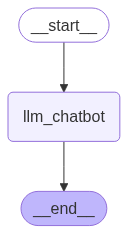

In [7]:
#Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
response = graph.invoke({"messages":["HI, how are you?"]})

In [9]:
response['messages'][-1].content

"Hi! I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have! How about you? How's your day going so far?"

In [10]:
#responses from llm chatbot 
for event in graph.stream({"messages":["Hello, how are you?"]}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have! It's great to chat with you. Is there something specific you'd like to talk about or ask about?


### Chatbot with Tavily

In [11]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=2)
search_tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is the Capital of France? - WorldAtlas',
   'url': 'https://www.worldatlas.com/articles/what-is-the-capital-of-france.html',
   'content': 'Paris is the capital city of France. Contrary to popular belief, the name of the city did not come from the Paris in Greek myths. Located in the north of Central France, the city is relatively flat with the highest point being 427 feet (which is Montmartre) above sea level while the lowest point is 115 feet above the sea level. With a GDP of approximately $850 billion, Paris is the country’s leader for economic activities. Tourists are attracted to Paris because of the rich history the city has including its monuments and sights. As the capital city of France, the city plays host to the national government of France. How Many Countries Are There In Africa? [x] Countries  All Countries',
   'score': 0.9170729,
   'ra

In [12]:
import requests

def get_weather(city: str) -> str:
    """Get the weather of a city

    Args:
        city (str): City name

    Returns:
        str: Weather description
    """
    api_key = "P8BBFAWX2NZRH9HZRU9UTFU7X"  # Replace with your actual API key
    #https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}?unitGroup=us&key={api_key}&contentType=json
    # api_key=os.getenv("WEATHER_API_KEY")
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}?unitGroup=us&key={api_key}&contentType=json"
    response = requests.get(url)
    data = response.json()
    weather = data['days'][0]["conditions"]
    temp = data["days"][0]["temp"]
    return f"The weather in {city} is {weather} with a temperature of {temp}°C."


In [13]:
tools=[search_tool, get_weather]

In [14]:
llm_with_tool = llm.bind_tools(tools)

In [15]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x116ba4220>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x116bc8a00>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

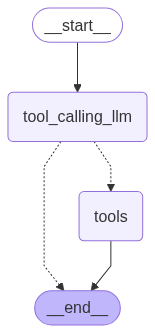

In [16]:
#State Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

#Node definition
def tool_calling_llm(state:State):
    return {"messages":llm_with_tool.invoke(state["messages"])}


#Graph definition

builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)

builder.add_node("tools",ToolNode(tools))

#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition)

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [22]:
response = graph.invoke({"messages":"What is latest ai news"})

In [23]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is latest ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (46k4x3c2b)
 Call ID: 46k4x3c2b
  Args:
    query: latest ai news
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "title": "Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai", "content": "Summary: Elon Musk's social media platform, X, has announced an upgrade to its AI chatbot, Grok, introducing advanced image editing features", "score": 0.79369855, "raw_content": null}, {"url": "https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAgfiK0i_tBxh4pjN2fQFA8uYK6cSdz114EKanJgFO3Ee_KsN8f_QP6Z&gaa_ts=68598af8&

In [24]:
response["messages"]

[HumanMessage(content='What is latest ai news', additional_kwargs={}, response_metadata={}, id='8697eba8-845f-4c80-a8f9-80ddcc19da5c'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '46k4x3c2b', 'function': {'arguments': '{"query":"latest ai news","search_depth":"advanced","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 2169, 'total_tokens': 2254, 'completion_time': 0.067407486, 'prompt_time': 0.239785055, 'queue_time': 0.008424674999999993, 'total_time': 0.307192541}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--be45d1b9-2d22-4149-8198-9a6448c10ebd-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'latest ai news', 'search_depth': 'advanced', 'topic': 'general'}, 'id': '46k4x3c2b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2169, 'output_tokens': 85, 'total_tokens'